In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [9]:
def import_csv(filename: str) -> pd.DataFrame:
    csv_path = filename
    return pd.read_csv(str(csv_path))

data_config = {
    "account_activity": "/account_activity.csv",
    "customer_data": "/customer_data.csv",
    "fraud_indicators": "/fraud_indicators.csv",
    "suspicious_activity": "/suspicious_activity.csv",
    "merchant_data": "/merchant_data.csv",
    "transaction_category_labels": "/transaction_category_labels.csv",
    "amount_data": "/amount_data.csv",
    "anomaly_scores": "/anomaly_scores.csv",
    "transaction_metadata": "/transaction_metadata.csv",
    "transaction_records": "/transaction_records.csv",
}

# Preload all datasets into a dictionary
datasets = {name: import_csv(path) for name, path in data_config.items()}

In [10]:
# Create dict with file names and column names
feature_names_by_file = {file_name: df.columns.tolist() for file_name, df in datasets.items()}

# Find the longest key
max_key_length = max(len(file_name) for file_name in feature_names_by_file.keys())

# Iterate over filenames and columns
for file_name, columns in feature_names_by_file.items():
    # Using just to align the filename in a field of width 'max_key_length'
    formatted_file_name = file_name.ljust(max_key_length)
    print(f"{formatted_file_name}: {', '.join(columns)}")

account_activity           : CustomerID, AccountBalance, LastLogin
customer_data              : CustomerID, Name, Age, Address
fraud_indicators           : TransactionID, FraudIndicator
suspicious_activity        : CustomerID, SuspiciousFlag
merchant_data              : MerchantID, MerchantName, Location
transaction_category_labels: TransactionID, Category
amount_data                : TransactionID, TransactionAmount
anomaly_scores             : TransactionID, AnomalyScore
transaction_metadata       : TransactionID, Timestamp, MerchantID
transaction_records        : TransactionID, Amount, CustomerID


In [11]:
import pandas as pd

#Assumption: The datasets have already been loaded and are available as Pandas DataFrames
#Example: customer_data = datasets['customer_data'], etc.

#Linking customer data
customer_info = pd.merge(datasets['customer_data'], datasets['account_activity'], on='CustomerID', how='left')
customer_info = pd.merge(customer_info, datasets['suspicious_activity'], on='CustomerID', how='left')

#Linking transaction data
transaction_info = pd.merge(datasets['transaction_metadata'], datasets['fraud_indicators'], on='TransactionID', how='left')
transaction_info = pd.merge(transaction_info, datasets['transaction_category_labels'], on='TransactionID', how='left')
transaction_info = pd.merge(transaction_info, datasets['amount_data'], on='TransactionID', how='left')
transaction_info = pd.merge(transaction_info, datasets['anomaly_scores'], on='TransactionID', how='left')

#Integration of merchant data
transaction_info = pd.merge(transaction_info, datasets['merchant_data'], on='MerchantID', how='left')

#Linking customer data and transaction data
#Since `transaction_records` contains both `CustomerID` and `TransactionID`, it can serve as a bridge
df = pd.merge(transaction_info, datasets['transaction_records'], on='TransactionID', how='left')
df = pd.merge(df, customer_info, on='CustomerID', how='left')
#Conversion of the timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#Checking the resulting table
df.head()

,TransactionID,Timestamp,MerchantID,FraudIndicator,Category,TransactionAmount,AnomalyScore,MerchantName,Location,Amount,CustomerID,Name,Age,Address,AccountBalance,LastLogin,SuspiciousFlag
0,1,2022-01-01 00:00:00,2701,0,Other,79.413607,0.686699,Merchant 2701,Location 2701,55.530334,1952,Customer 1952,50,Address 1952,2869.689912,2024-08-09,0
1,2,2022-01-01 01:00:00,2070,0,Online,12.053087,0.081749,Merchant 2070,Location 2070,12.881180,1027,Customer 1027,46,Address 1027,9527.947107,2022-01-27,0
2,3,2022-01-01 02:00:00,2238,0,Travel,33.310357,0.023857,Merchant 2238,Location 2238,50.176322,1955,Customer 1955,34,Address 1955,9288.355525,2024-08-12,0
3,4,2022-01-01 03:00:00,2879,0,Travel,46.121117,0.876994,Merchant 2879,Location 2879,41.634001,1796,Customer 1796,33,Address 1796,5588.049942,2024-03-06,0
4,5,2022-01-01 04:00:00,2966,0,Other,54.051618,0.034059,Merchant 2966,Location 2966,78.122853,1946,Customer 1946,18,Address 1946,7324.785332,2024-08-03,0


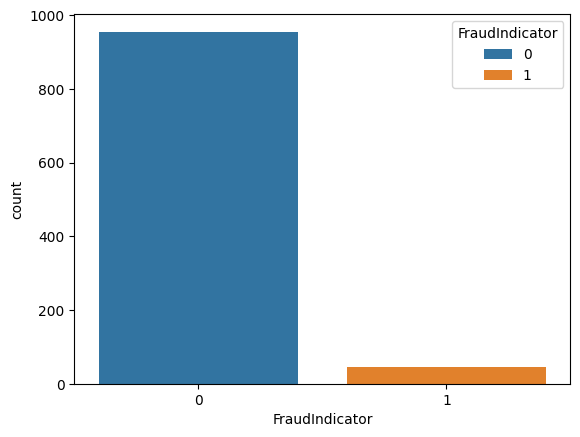

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

#Plotting the binary target variable FraudIndicator
sns.countplot(x='FraudIndicator', data=df, hue='FraudIndicator')

plt.show()

In [13]:
sum(df["FraudIndicator"])

45

In [15]:
import networkx as nx
import plotly.graph_objs as go
import pandas as pd

#Assume 'final_table' is your combined DataFrame and already loaded
#Create the graph
G = nx.Graph()

#Add nodes for customers, transactions and merchants
for index, row in df.iterrows():
    G.add_node(f"C{row['CustomerID']}", type='Customer', fraud=row['FraudIndicator'] == 1)
    G.add_node(f"T{row['TransactionID']}", type='Transaction')
    G.add_node(f"M{row['MerchantID']}", type='Merchant')

    #Add edges
    G.add_edge(f"C{row['CustomerID']}", f"T{row['TransactionID']}")
    G.add_edge(f"T{row['TransactionID']}", f"M{row['MerchantID']}")

#Calculating the positions for each node in 3D
pos = nx.spring_layout(G, dim=3)

#Extract the x, y, z positions into separate lists
x_nodes = [pos[node][0] for node in G.nodes()]  # x Position
y_nodes = [pos[node][1] for node in G.nodes()]  # y Position
z_nodes = [pos[node][2] for node in G.nodes()]  # z Position

#Node colors based on fraud indicator
node_color = ['red' if G.nodes[node]['type'] == 'Customer' and G.nodes[node]['fraud'] else 'blue' for node in G.nodes()]

#Create the 3D Plotly graph data
trace_nodes = go.Scatter3d(x=x_nodes, y=y_nodes, z=z_nodes, mode='markers', marker=dict(size=6, color=node_color))

#Prepare edges for the Plotly graph
edge_x = []
edge_y = []
edge_z = []
for edge in G.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_z.extend([z0, z1, None])

trace_edges = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', line=dict(color='black', width=1))

#Define the layout for the 3D visualization
layout = go.Layout(title="Network of customers, transactions and merchants", showlegend=False)

#Combine the node and edge data for the plot
fig = go.Figure(data=[trace_edges, trace_nodes], layout=layout)

#Show the plot
fig.show()